In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors


In [2]:
dfA = pd.read_csv('../data/processed/dataset_large_simple.csv')
dfB = pd.read_csv('../data/processed/dataset_small_rich.csv')  
dfC = pd.read_csv('../data/processed/dataset_large_rich_filled_final.csv')

In [3]:
print(dfA.columns)


Index(['city_code', 'city_name', 'avg_salary', 'avg_salary_female',
       'avg_salary_male', 'log_gender_gap', 'population_total',
       'population_30_44', 'population_female', 'population_cs3', 'latitude',
       'longitude', 'vote_macron_share'],
      dtype='object')


In [4]:
print(dfB.shape)
dfB.columns

(100, 68)


Index(['city_code', 'city_name', 'avg_salary', 'avg_salary_female',
       'avg_salary_male', 'log_gender_gap', 'population_total',
       'population_30_44', 'population_female', 'population_cs3', 'latitude',
       'longitude', 'vote_macron_share', 'Ville', 'Chomage', 'ChomageJeunes',
       'ChomageLong', 'EvoluEmploiCree', 'Activite', 'EmploiFeminin',
       'EmploiCommune', 'DefaillEntreprise', 'SalaireAnnuel', 'Criminalite',
       'EvolutionCrimes', 'SecuriteRoutiere', 'Inondations', 'TerrainsPollues',
       'UsinesRisques', 'MortaliteInfantile', 'MortaliteCancerPoumon',
       'MortaliteAlcool', 'DecesInfarctus', 'TauxSuicide', 'MortaliteGlobale',
       'TailleClassesPrimaires', 'Retard6eme', 'Retard3eme', 'RetardTerminale',
       'MetreCarreAncien', 'TaxeHabitation', 'FoncierBati', 'MetreCubeEau',
       'Proprietaires', 'LogtSup4pieces', 'LogtInsalubre', 'LogtVacant',
       'LogtConstruction', 'Mer', 'Ski', 'Soleil', 'Pluie', 'Temperature',
       'MarcheAPied', 'Musees',

In [5]:
print(dfC.shape)
dfC.info()

(5263, 68)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5263 entries, 0 to 5262
Data columns (total 68 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_code               5263 non-null   object 
 1   city_name               5263 non-null   object 
 2   avg_salary              5263 non-null   float64
 3   avg_salary_female       5263 non-null   float64
 4   avg_salary_male         5263 non-null   float64
 5   log_gender_gap          5263 non-null   float64
 6   population_total        5263 non-null   int64  
 7   population_30_44        5263 non-null   float64
 8   population_female       5263 non-null   float64
 9   population_cs3          5263 non-null   float64
 10  latitude                5263 non-null   float64
 11  longitude               5263 non-null   float64
 12  vote_macron_share       5263 non-null   float64
 13  Chomage                 5263 non-null   float64
 14  ChomageJeunes           5263 

In [6]:

cols = ["avg_salary", "avg_salary_male", "avg_salary_female"]
print(dfA[cols].corr())


dfA["avg_salary_mean"] = (dfA["avg_salary_male"] + dfA["avg_salary_female"]) / 2
dfA["diff"] = dfA["avg_salary"] - dfA["avg_salary_mean"]

print(dfA["diff"].describe())



                   avg_salary  avg_salary_male  avg_salary_female
avg_salary           1.000000         0.994041           0.966929
avg_salary_male      0.994041         1.000000           0.935661
avg_salary_female    0.966929         0.935661           1.000000
count    5263.000000
mean        0.233842
std         0.151119
min        -0.177867
25%         0.147942
50%         0.209313
75%         0.285319
max         3.445467
Name: diff, dtype: float64


In [7]:
TARGET = "log_gender_gap"

ID_COLS = ["city_code","city_name","Ville","LIBGEO","Commune","Code_INSEE","INSEE"]

LEAKY_COLS = ["avg_salary","avg_salary_male","avg_salary_female"]
DERIVED_COLS= ['avg_salary_mean','diff'] 


ban = set(ID_COLS + LEAKY_COLS + DERIVED_COLS + [TARGET])
BASE_FEATURES = [c for c in dfA.columns if c in dfB.columns and c not in ban]
print("BASE_FEATURES =", BASE_FEATURES)

RICH_FEATURES = [c for c in dfB.columns if c not in ban and c not in BASE_FEATURES]
print("len(RICH_FEATURES) =", len(RICH_FEATURES))

BASE_FEATURES = ['population_total', 'population_30_44', 'population_female', 'population_cs3', 'latitude', 'longitude', 'vote_macron_share']
len(RICH_FEATURES) = 54


In [8]:
RANDOM_STATE = 42 

def clean_drop(df):
    df = df.copy()
    for c in df.columns:
        if c not in ID_COLS:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.drop(columns=[c for c in ID_COLS+LEAKY_COLS+DERIVED_COLS if c in df.columns], errors="ignore")

A = clean_drop(dfA)
B = clean_drop(dfB)


A_train, A_test = train_test_split(A, test_size=0.2, random_state=RANDOM_STATE)
print("A_train/A_test:", A_train.shape, A_test.shape)


X_ref = B[BASE_FEATURES].to_numpy(dtype=float)
Y_ref = B[RICH_FEATURES].to_numpy(dtype=float)


scaler = StandardScaler().fit(A_train[BASE_FEATURES].to_numpy(dtype=float))
X_ref_s = scaler.transform(X_ref)


def adaptive_knn_fill(X_ref_s, Y_ref, X_query_s, k=7):
    nn = NearestNeighbors(n_neighbors=k).fit(X_ref_s)
    D, I = nn.kneighbors(X_query_s)             

    sigma = np.median(D, axis=1, keepdims=True)
    sigma = np.where(sigma < 1e-8, 1e-8, sigma)
    W = np.exp(-(D**2) / (2 * sigma**2))
    W = W / np.clip(W.sum(axis=1, keepdims=True), 1e-12, None)
  
    Y_hat = (W[:, :, None] * Y_ref[I]).sum(axis=1)
    return Y_hat


def build_C_from_Apart(A_part):
    Xq_s = scaler.transform(A_part[BASE_FEATURES].to_numpy(dtype=float))
    Yhat = adaptive_knn_fill(X_ref_s, Y_ref, Xq_s, k=7)
    C_part = A_part.copy()
    C_part[RICH_FEATURES] = Yhat
    return C_part

C_train = build_C_from_Apart(A_train)
C_test  = build_C_from_Apart(A_test)

print("C_train/C_test:", C_train.shape, C_test.shape)


A_train/A_test: (4210, 8) (1053, 8)
C_train/C_test: (4210, 62) (1053, 62)


In [9]:
A.columns

Index(['log_gender_gap', 'population_total', 'population_30_44',
       'population_female', 'population_cs3', 'latitude', 'longitude',
       'vote_macron_share'],
      dtype='object')

In [10]:
B.columns

Index(['log_gender_gap', 'population_total', 'population_30_44',
       'population_female', 'population_cs3', 'latitude', 'longitude',
       'vote_macron_share', 'Chomage', 'ChomageJeunes', 'ChomageLong',
       'EvoluEmploiCree', 'Activite', 'EmploiFeminin', 'EmploiCommune',
       'DefaillEntreprise', 'SalaireAnnuel', 'Criminalite', 'EvolutionCrimes',
       'SecuriteRoutiere', 'Inondations', 'TerrainsPollues', 'UsinesRisques',
       'MortaliteInfantile', 'MortaliteCancerPoumon', 'MortaliteAlcool',
       'DecesInfarctus', 'TauxSuicide', 'MortaliteGlobale',
       'TailleClassesPrimaires', 'Retard6eme', 'Retard3eme', 'RetardTerminale',
       'MetreCarreAncien', 'TaxeHabitation', 'FoncierBati', 'MetreCubeEau',
       'Proprietaires', 'LogtSup4pieces', 'LogtInsalubre', 'LogtVacant',
       'LogtConstruction', 'Mer', 'Ski', 'Soleil', 'Pluie', 'Temperature',
       'MarcheAPied', 'Musees', 'Cinema', 'MonumHistoriques', 'PretLivres',
       'RestaurDistingues', 'Presse', 'Etudiants', 

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.metrics._regression")

In [12]:
def split_Xy(df):

    y = pd.to_numeric(df[TARGET], errors="coerce")
    
    drop_cols = [c for c in (ID_COLS + LEAKY_COLS + DERIVED_COLS + [TARGET]) if c in df.columns]
    
    X = df.drop(columns=drop_cols, errors="ignore")
    
    return X, y

In [ ]:
def make_preprocessor(X, scale_numeric=False):
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        num_steps.append(("scaler", StandardScaler()))
    num_pipe = Pipeline(num_steps)
    
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ], remainder="drop")
    return pre

def fit_eval_dataset(dataset_name, train_df, test_df):
    X_train, y_train = split_Xy(train_df)
    X_test,  y_test  = split_Xy(test_df)

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    configs = {
        "Ridge": {
            "estimator": Ridge(),
            "scale": True,
            "param_grid": {"model__alpha":[0.1, 1.0, 3.0, 10.0]}
        },
        "SVR": {
            "estimator": SVR(),
            "scale": True,
            "param_grid": {
                "model__C":[1, 3, 10, 30],
                "model__epsilon":[0.01, 0.05, 0.1],
                "model__gamma":["scale", "auto"]
            }
        },
        "DecisionTree": {
            "estimator": DecisionTreeRegressor(random_state=RANDOM_STATE),
            "scale": False,
            "param_grid": {
                "model__max_depth":[3, 6, 10, None],
                "model__min_samples_leaf":[1, 3, 10]
            }
        },
        "RandomForest": {
            "estimator": RandomForestRegressor(
                n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1
            ),
            "scale": False,
            "param_grid": {
                "model__max_depth":[None, 10, 20],
                "model__min_samples_split":[2, 5],
                "model__max_features":["sqrt", "log2", None]
            }
        }
    }

    results = []
    for name, cfg in configs.items():
        pre = make_preprocessor(X_train, scale_numeric=cfg["scale"])
        pipe = Pipeline([("pre", pre), ("model", cfg["estimator"])])

        gs = GridSearchCV(
            pipe, cfg["param_grid"], cv=cv, scoring="r2",
            n_jobs=-1, refit=True, verbose=0
        )
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)

        results.append({
            "dataset": dataset_name,
            "model": name,
            "R2": r2,
            "RMSE": rmse,
            "MAE": mae,
            "best_params": gs.best_params_
        })
        print(f"{dataset_name} | {name:12s}  R²={r2:6.3f}  RMSE={rmse:7.4f}  MAE={mae:7.4f}  {gs.best_params_}")

    return pd.DataFrame(results)


In [15]:

df_res_A = fit_eval_dataset("A (base)", A_train, A_test)


df_res_C = fit_eval_dataset("C (base + rich_imputed)", C_train, C_test)


baseline_compare = pd.concat([df_res_A, df_res_C], ignore_index=True)
print("\n=== Baseline Comparison (same test set) ===")
print(baseline_compare[["dataset","model","R2","RMSE","MAE","best_params"]]
      .sort_values(["model","dataset"]).to_string(index=False))


A (base) | Ridge         R²=-1.830  RMSE= 0.1114  MAE= 0.0491  {'model__alpha': 3.0}
A (base) | SVR           R²= 0.412  RMSE= 0.0508  MAE= 0.0386  {'model__C': 10, 'model__epsilon': 0.01, 'model__gamma': 'scale'}
A (base) | DecisionTree  R²= 0.256  RMSE= 0.0571  MAE= 0.0433  {'model__max_depth': 6, 'model__min_samples_leaf': 10}
A (base) | RandomForest  R²= 0.427  RMSE= 0.0502  MAE= 0.0380  {'model__max_depth': 20, 'model__max_features': None, 'model__min_samples_split': 5}
C (base + rich_imputed) | Ridge         R²=-2.458  RMSE= 0.1232  MAE= 0.0488  {'model__alpha': 10.0}
C (base + rich_imputed) | SVR           R²= 0.340  RMSE= 0.0538  MAE= 0.0408  {'model__C': 10, 'model__epsilon': 0.01, 'model__gamma': 'scale'}
C (base + rich_imputed) | DecisionTree  R²= 0.244  RMSE= 0.0576  MAE= 0.0441  {'model__max_depth': 6, 'model__min_samples_leaf': 10}
C (base + rich_imputed) | RandomForest  R²= 0.415  RMSE= 0.0507  MAE= 0.0387  {'model__max_depth': 20, 'model__max_features': None, 'model__mi

In [ ]:
from sklearn.metrics import root_mean_squared_error

In [22]:
from sklearn.model_selection import KFold, cross_validate
def cv_on_B(dfB):
   
    Xb, yb = split_Xy(dfB)
    pre = make_preprocessor(Xb, scale_numeric=False)

    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    pipes = {
        "Ridge": Pipeline([("pre", make_preprocessor(Xb, True)),
                           ("model", Ridge(alpha=3.0))]),
        "SVR": Pipeline([("pre", make_preprocessor(Xb, True)),
                         ("model", SVR(C=10, epsilon=0.05, gamma="scale"))]),
        "DecisionTree": Pipeline([("pre", make_preprocessor(Xb, False)),
                                  ("model", DecisionTreeRegressor(max_depth=6, min_samples_leaf=5,
                                                                 random_state=RANDOM_STATE))]),
        "RandomForest": Pipeline([("pre", make_preprocessor(Xb, False)),
                                  ("model", RandomForestRegressor(n_estimators=400, max_depth=None,
                                                                  max_features="sqrt",
                                                                  random_state=RANDOM_STATE, n_jobs=-1))]),
    }

    rows = []
    for name, pipe in pipes.items():
        scores = cross_validate(
            pipe, Xb, yb, cv=cv, n_jobs=-1, return_train_score=False,
            scoring={"r2":"r2",
                     "rmse":"neg_root_mean_squared_error",
                     "mae":"neg_mean_absolute_error"}
        )

        
        print(f"\nB | {name} (5-fold)")
        print(f"  R²   = {scores['test_r2'].mean():.3f} ± {scores['test_r2'].std():.3f}")
        print(f"  RMSE = {-scores['test_rmse'].mean():.4f}")
        print(f"  MAE  = {-scores['test_mae'].mean():.4f}")
        
cv_on_B(dfB)



B | Ridge (5-fold)
  R²   = -2.044 ± 2.701
  RMSE = 0.1015
  MAE  = 0.0556

B | SVR (5-fold)
  R²   = 0.008 ± 0.566
  RMSE = 0.0590
  MAE  = 0.0411

B | DecisionTree (5-fold)
  R²   = 0.159 ± 0.404
  RMSE = 0.0548
  MAE  = 0.0433

B | RandomForest (5-fold)
  R²   = 0.439 ± 0.215
  RMSE = 0.0460
  MAE  = 0.0319


In [24]:
import pandas as pd


results_ac = [
    {"Dataset": "A (large simple)", "Model": "Ridge",         "R2": -1.8302, "RMSE": 0.1114, "MAE": 0.0491},
    {"Dataset": "A (large simple)", "Model": "SVR",           "R2": 0.4119,  "RMSE": 0.0508, "MAE": 0.0386},
    {"Dataset": "A (large simple)", "Model": "DecisionTree",  "R2": 0.2557,  "RMSE": 0.0571, "MAE": 0.0433},
    {"Dataset": "A (large simple)", "Model": "RandomForest",  "R2": 0.4266,  "RMSE": 0.0502, "MAE": 0.0380},

    {"Dataset": "C (Base + Rich Imputed)", "Model": "Ridge", "R2": -2.4582, "RMSE": 0.1232, "MAE": 0.0488},
    {"Dataset": "C (Base + Rich Imputed)", "Model": "SVR", "R2": 0.3403,  "RMSE": 0.0538, "MAE": 0.0408},
    {"Dataset": "C (Base + Rich Imputed)", "Model": "DecisionTree", "R2": 0.2440, "RMSE": 0.0576, "MAE": 0.0441},
    {"Dataset": "C (Base + Rich Imputed)", "Model": "RandomForest", "R2": 0.4146, "RMSE": 0.0507, "MAE": 0.0387},
]

results_b = [
    {"Dataset": "B (Rich Small)", "Model": "Ridge", "R2": "-2.044 ± 2.701", "RMSE": 0.1015, "MAE": 0.0556},
    {"Dataset": "B (Rich Small)", "Model": "SVR",   "R2": "0.008 ± 0.566",  "RMSE": 0.0590, "MAE": 0.0411},
    {"Dataset": "B (Rich Small)", "Model": "DecisionTree", "R2": "0.159 ± 0.404", "RMSE": 0.0548, "MAE": 0.0433},
    {"Dataset": "B (Rich Small)", "Model": "RandomForest", "R2": "0.439 ± 0.215", "RMSE": 0.0460, "MAE": 0.0319},
]


results_all = pd.DataFrame(results_ac + results_b)

print(results_all)



                    Dataset         Model              R2    RMSE     MAE
0          A (large simple)         Ridge         -1.8302  0.1114  0.0491
1          A (large simple)           SVR          0.4119  0.0508  0.0386
2          A (large simple)  DecisionTree          0.2557  0.0571  0.0433
3          A (large simple)  RandomForest          0.4266  0.0502  0.0380
4   C (Base + Rich Imputed)         Ridge         -2.4582  0.1232  0.0488
5   C (Base + Rich Imputed)           SVR          0.3403  0.0538  0.0408
6   C (Base + Rich Imputed)  DecisionTree           0.244  0.0576  0.0441
7   C (Base + Rich Imputed)  RandomForest          0.4146  0.0507  0.0387
8            B (Rich Small)         Ridge  -2.044 ± 2.701  0.1015  0.0556
9            B (Rich Small)           SVR   0.008 ± 0.566  0.0590  0.0411
10           B (Rich Small)  DecisionTree   0.159 ± 0.404  0.0548  0.0433
11           B (Rich Small)  RandomForest   0.439 ± 0.215  0.0460  0.0319


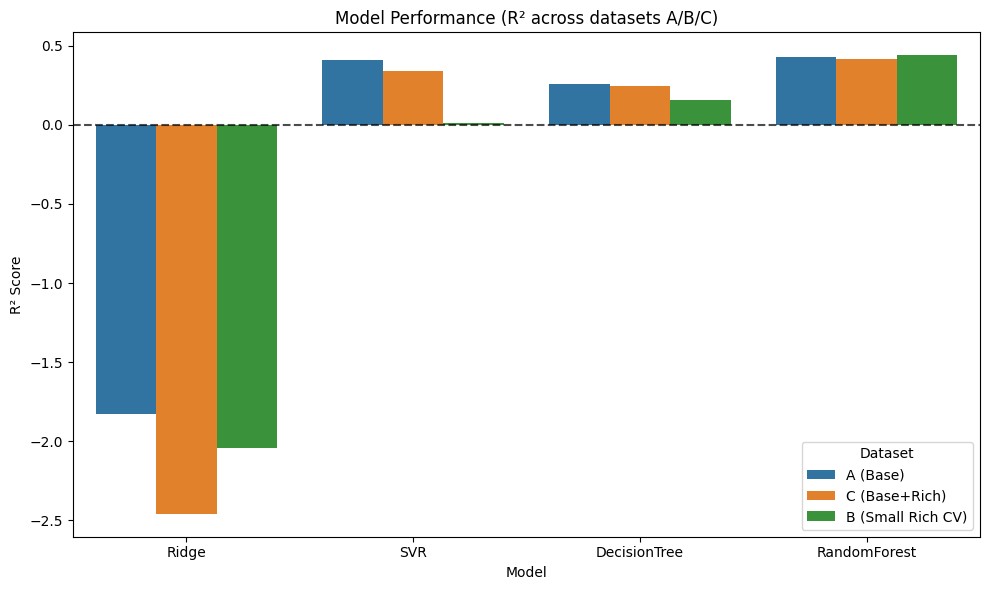

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


results_plot = [
    {"Dataset": "A (Base)", "Model": "Ridge", "R2": -1.8302},
    {"Dataset": "C (Base+Rich)", "Model": "Ridge", "R2": -2.4582},
    {"Dataset": "B (Small Rich CV)", "Model": "Ridge", "R2": -2.044}, 

    {"Dataset": "A (Base)", "Model": "SVR", "R2": 0.4119},
    {"Dataset": "C (Base+Rich)", "Model": "SVR", "R2": 0.3403},
    {"Dataset": "B (Small Rich CV)", "Model": "SVR", "R2": 0.008},

    {"Dataset": "A (Base)", "Model": "DecisionTree", "R2": 0.2557},
    {"Dataset": "C (Base+Rich)", "Model": "DecisionTree", "R2": 0.2440},
    {"Dataset": "B (Small Rich CV)", "Model": "DecisionTree", "R2": 0.159},

    {"Dataset": "A (Base)", "Model": "RandomForest", "R2": 0.4266},
    {"Dataset": "C (Base+Rich)", "Model": "RandomForest", "R2": 0.4146},
    {"Dataset": "B (Small Rich CV)", "Model": "RandomForest", "R2": 0.439},
]

df_plot = pd.DataFrame(results_plot)

plt.figure(figsize=(10,6))
sns.barplot(data=df_plot, x="Model", y="R2", hue="Dataset")

plt.title("Model Performance (R² across datasets A/B/C)")
plt.ylabel("R² Score")
plt.legend(title="Dataset")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


In [28]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.base import clone
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

TEST_SIZE = 0.2
CV_SPLITS = 5
RANDOM_STATE = 42

def run_rfe_multimodel_on_C_train_test(C_train, C_test):
    X_train, y_train = split_Xy(C_train)
    X_test,  y_test  = split_Xy(C_test)

    configs = {
        "Ridge": {
            "scale": True,
            "rfe_estimator":   Ridge(alpha=3.0),
            "final_estimator": Ridge(alpha=3.0)
        },
        "SVR": {
            "scale": True,
      
            "rfe_estimator":   LinearSVR(C=3.0, epsilon=0.05,
                                         random_state=RANDOM_STATE, max_iter=5000),
        
            "final_estimator": SVR(C=10, epsilon=0.05, gamma="scale", kernel="rbf")
        },
        "DecisionTree": {
            "scale": False,
            "rfe_estimator":   DecisionTreeRegressor(max_depth=6, min_samples_leaf=5,
                                                     random_state=RANDOM_STATE),
            "final_estimator": DecisionTreeRegressor(max_depth=6, min_samples_leaf=5,
                                                     random_state=RANDOM_STATE)
        },
        "RandomForest": {
            "scale": False,
            "rfe_estimator":   RandomForestRegressor(n_estimators=400, max_depth=None,
                                                     max_features="sqrt",
                                                     random_state=RANDOM_STATE, n_jobs=-1),
            "final_estimator": RandomForestRegressor(n_estimators=400, max_depth=None,
                                                     max_features="sqrt",
                                                     random_state=RANDOM_STATE, n_jobs=-1)
        }
    }

    rows, selected_feature_dict = [], {}

    for name, cfg in configs.items():
        pre = make_preprocessor(X_train, scale_numeric=cfg["scale"])
        pre.fit(X_train)

        try:
            feature_names = pre.get_feature_names_out()
        except:
            num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
            cat_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
            feature_names = np.array(list(num_cols) + list(cat_cols))

        Xtr = pre.transform(X_train)
        Xte = pre.transform(X_test)

     
        rfe_est = cfg["rfe_estimator"]

        rfecv = RFECV(
            estimator=rfe_est,
            step=1,
            cv=KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE),
            scoring='r2',
            n_jobs=-1
        )
        rfecv.fit(Xtr, y_train)

        mask = rfecv.support_
        Xtr_sel = Xtr[:, mask]
        Xte_sel = Xte[:, mask]

        final_est = clone(cfg["final_estimator"])
        final_est.fit(Xtr_sel, y_train)
        y_pred = final_est.predict(Xte_sel)

        r2  = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mae = mean_absolute_error(y_test, y_pred)

        try:
            selected_cols = np.array(feature_names)[mask].tolist()
        except:
            selected_cols = [f"f_{i}" for i, m in enumerate(mask) if m]

     
        rich_count = 0
        for sc in selected_cols:
            col = sc.split("__")[-1]
            base = col.split("_")[0]
            if any(col.startswith(r) or base == r for r in RICH_FEATURES):
                rich_count += 1

        rows.append({
            "model": name,
            "n_selected": int(mask.sum()),
            "R2": r2, "RMSE": rmse, "MAE": mae,
            "rich_selected": rich_count,
            "rich_ratio": rich_count / max(1, int(mask.sum()))
        })
        selected_feature_dict[name] = selected_cols

        print(f"\n[RFE] {name}")
        print(f"  Selected features: {int(mask.sum())} | R²={r2:.3f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
        print(f"  Rich kept: {rich_count} ({rich_count/max(1,int(mask.sum())):.1%})")

    res_df = pd.DataFrame(rows).sort_values("R2", ascending=False).reset_index(drop=True)
    print("\n=== RFE Summary on Dataset C (same test set as baseline) ===")
    print(res_df.to_string(index=False))
    return res_df, selected_feature_dict

In [29]:
rfe_results_df, rfe_selected = run_rfe_multimodel_on_C_train_test(C_train, C_test)


[RFE] Ridge
  Selected features: 9 | R²=-1.779, RMSE=0.1104, MAE=0.0486
  Rich kept: 4 (44.4%)


c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



[RFE] SVR
  Selected features: 17 | R²=0.363, RMSE=0.0528, MAE=0.0403
  Rich kept: 12 (70.6%)

[RFE] DecisionTree
  Selected features: 4 | R²=0.241, RMSE=0.0577, MAE=0.0437
  Rich kept: 0 (0.0%)

[RFE] RandomForest
  Selected features: 9 | R²=0.425, RMSE=0.0502, MAE=0.0382
  Rich kept: 2 (22.2%)

=== RFE Summary on Dataset C (same test set as baseline) ===
       model  n_selected        R2     RMSE      MAE  rich_selected  rich_ratio
RandomForest           9  0.425097 0.050218 0.038184              2    0.222222
         SVR          17  0.363286 0.052849 0.040295             12    0.705882
DecisionTree           4  0.240715 0.057712 0.043731              0    0.000000
       Ridge           9 -1.779414 0.110419 0.048624              4    0.444444


In [32]:
rf_selected = rfe_selected["RandomForest"]

print("\n=== RFE - RandomForest Selected Features (Dataset C) ===")
print(f"{len(rf_selected)} :\n")

base_feats, rich_feats = [], []

for feat in rf_selected:
 
    clean_name = feat.split("__")[-1]

    if clean_name in BASE_FEATURES:
        base_feats.append(clean_name)
    elif clean_name in RICH_FEATURES:
        rich_feats.append(clean_name)

print("Base Features (Real basic features):")
for f in base_feats:
    print(" -", f)

print("\nRich Features (Characteristics of KNN imputation):")
for f in rich_feats:
    print(" -", f)

print(f"\nBase = {len(base_feats)}, Rich = {len(rich_feats)}")



=== RFE - RandomForest Selected Features (Dataset C) ===
9 :

Base Features (Real basic features):
 - population_total
 - population_30_44
 - population_female
 - population_cs3
 - latitude
 - longitude
 - vote_macron_share

Rich Features (Characteristics of KNN imputation):
 - EmploiCommune
 - Presse

Base = 7, Rich = 2


In [33]:


selected_svr = rfe_selected["SVR"]  
base_feats = []
rich_feats = []

for sc in selected_svr:
    col = sc.split("__")[-1]  
    base = col.split("_")[0]  
    if col in RICH_FEATURES:
        rich_feats.append(col)
    else:
        base_feats.append(col)

print("\n=== RFE - SVR Selected Features (Dataset C) ===")
print(f" {len(selected_svr)} :\n")

print("Base Features (Real basic features):")
for f in base_feats:
    print(" -", f)

print("\nRich Features (Characteristics of KNN imputation):")
for f in rich_feats:
    print(" -", f)

print(f"\n: Base = {len(base_feats)}, Rich = {len(rich_feats)}")



=== RFE - SVR Selected Features (Dataset C) ===
 17 :

Base Features (Real basic features):
 - population_total
 - population_30_44
 - population_female
 - population_cs3
 - vote_macron_share

Rich Features (Characteristics of KNN imputation):
 - Activite
 - SalaireAnnuel
 - MortaliteInfantile
 - MortaliteAlcool
 - MortaliteGlobale
 - MetreCubeEau
 - Musees
 - ImpotRevenu
 - ImpotFortune
 - Vieillissement
 - AttiranceGlobale
 - AttiranceActifs

: Base = 5, Rich = 12


method 2:Isolation Test

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

def isolation_test(C_train, C_test, rich_features, geo_features=["latitude","longitude"]):


   
    Xtr_rich = C_train[rich_features]
    ytr = C_train[TARGET]
    Xte_rich = C_test[rich_features]
    yte = C_test[TARGET]


    rf = RandomForestRegressor(
        n_estimators=400, max_depth=None, max_features="sqrt",
        random_state=RANDOM_STATE, n_jobs=-1
    )
    rf.fit(Xtr_rich, ytr)
    ypred_rich = rf.predict(Xte_rich)
    res_rich = {
        "dataset":"C (Rich-only)",
        "R2": r2_score(yte, ypred_rich),
        "RMSE": mean_squared_error(yte, ypred_rich, squared=False),
        "MAE": mean_absolute_error(yte, ypred_rich)
    }

 
    rich_geo_features = rich_features + [g for g in geo_features if g in C_train.columns]
    Xtr_richgeo = C_train[rich_geo_features]
    Xte_richgeo = C_test[rich_geo_features]

    rf2 = RandomForestRegressor(
        n_estimators=400, max_depth=None, max_features="sqrt",
        random_state=RANDOM_STATE, n_jobs=-1
    )
    rf2.fit(Xtr_richgeo, ytr)
    ypred_richgeo = rf2.predict(Xte_richgeo)
    res_richgeo = {
        "dataset":"C (Rich+Geo)",
        "R2": r2_score(yte, ypred_richgeo),
        "RMSE": mean_squared_error(yte, ypred_richgeo, squared=False),
        "MAE": mean_absolute_error(yte, ypred_richgeo)
    }


    res_df = pd.DataFrame([res_rich, res_richgeo])
    print("\n=== Isolation Test Results ===")
    print(res_df.to_string(index=False))
    return res_df


rich_features = [c for c in RICH_FEATURES if c in C_train.columns]

for df_ in (C_train, C_test):
    df_[rich_features + BASE_FEATURES + [TARGET]] = df_[rich_features + BASE_FEATURES + [TARGET]].apply(
        pd.to_numeric, errors="coerce"
    )

isolation_results = isolation_test(C_train, C_test, rich_features)



=== Isolation Test Results ===
      dataset       R2     RMSE      MAE
C (Rich-only) 0.335962 0.053971 0.041533
 C (Rich+Geo) 0.363452 0.052842 0.040530


In [45]:

def eval_subset_rf(C_train, C_test, feature_names, label=""):
    Xtr = C_train[feature_names].copy(); ytr = C_train[TARGET].copy()
    Xte = C_test[feature_names].copy();  yte = C_test[TARGET].copy()
    pre = make_preprocessor(Xtr, scale_numeric=False)
    rf  = RandomForestRegressor(n_estimators=400, max_depth=None, max_features="sqrt",
                                random_state=RANDOM_STATE, n_jobs=-1)
    pipe = Pipeline([("pre", pre), ("model", rf)])
    pipe.fit(Xtr, ytr)
    yp = pipe.predict(Xte)
    return {
        "setting": label,
        "R2": r2_score(yte, yp),
        "RMSE": mean_squared_error(yte, yp, squared=False),
        "MAE": mean_absolute_error(yte, yp)
    }

BASE = BASE_FEATURES
RICH_MINI = [c for c in ["EmploiCommune","Presse"] if c in C_train.columns]
RICH_ECON = [c for c in ["SalaireAnnuel","ImpotRevenu","ImpotFortune","Imposables"] if c in C_train.columns]
BASE_PLUS_MINI = BASE + RICH_MINI
BASE_PLUS_ECON = BASE + RICH_ECON
BASE_PLUS_BOTH = BASE + list(dict.fromkeys(RICH_MINI + RICH_ECON))

rows = []
rows.append(eval_subset_rf(C_train, C_test, BASE, "Base-only"))
if RICH_MINI: rows.append(eval_subset_rf(C_train, C_test, BASE_PLUS_MINI, "Base + {EmploiCommune,Presse}"))
if RICH_ECON: rows.append(eval_subset_rf(C_train, C_test, BASE_PLUS_ECON, "Base + Economic(core)"))
if RICH_MINI or RICH_ECON: rows.append(eval_subset_rf(C_train, C_test, BASE_PLUS_BOTH, "Base + Mini + Economic"))

res_df = pd.DataFrame(rows).sort_values("R2", ascending=False).reset_index(drop=True)
print("\n=== Compact Combo Test (same train/test as baseline) ===")
print(res_df.to_string(index=False))


=== Compact Combo Test (same train/test as baseline) ===
                      setting       R2     RMSE      MAE
Base + {EmploiCommune,Presse} 0.425097 0.050218 0.038184
       Base + Mini + Economic 0.420388 0.050424 0.038380
        Base + Economic(core) 0.410261 0.050862 0.038418
                    Base-only 0.409891 0.050878 0.038384


In [46]:

def metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred),
    }

def train_rf_pipeline(X_train, y_train, scale_numeric=False,
                      n_estimators=400, max_depth=None, max_features="sqrt"):
  
    pre = make_preprocessor(X_train, scale_numeric=scale_numeric)
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    pipe = Pipeline([("pre", pre), ("model", rf)])
    pipe.fit(X_train, y_train)
    return pipe


XA_tr = C_train[BASE_FEATURES]  
yA_tr = C_train[TARGET]
XA_te = C_test[BASE_FEATURES]



model_A = train_rf_pipeline(XA_tr, yA_tr, scale_numeric=False)

XB_tr = dfB[RICH_FEATURES].copy()
yB_tr = dfB[TARGET].copy()
XB_te = C_test[RICH_FEATURES].copy()

model_B = train_rf_pipeline(XB_tr, yB_tr, scale_numeric=False)


pred_A_te = model_A.predict(XA_te)
pred_B_te = model_B.predict(XB_te)
pred_avg_te = 0.5 * (pred_A_te + pred_B_te)

avg_res = metrics(C_test[TARGET].values, pred_avg_te)

print("\n=== Ensemble: Simple Averaging (on C_test) ===")
print(f"R2={avg_res['R2']:.3f}  RMSE={avg_res['RMSE']:.4f}  MAE={avg_res['MAE']:.4f}")


single_A_res = metrics(C_test[TARGET].values, pred_A_te)
single_B_res = metrics(C_test[TARGET].values, pred_B_te)
print("\n-- Single models on C_test --")
print(f"A-only (Base): R2={single_A_res['R2']:.3f}  RMSE={single_A_res['RMSE']:.4f}  MAE={single_A_res['MAE']:.4f}")
print(f"B-only (Rich): R2={single_B_res['R2']:.3f}  RMSE={single_B_res['RMSE']:.4f}  MAE={single_B_res['MAE']:.4f}")


XA_tr2 = C_train[BASE_FEATURES]
XB_tr2 = C_train[RICH_FEATURES]

pred_A_tr = model_A.predict(XA_tr2)
pred_B_tr = model_B.predict(XB_tr2)
meta_X_tr = np.column_stack([pred_A_tr, pred_B_tr])    
meta_y_tr = C_train[TARGET].values


meta_X_te = np.column_stack([pred_A_te, pred_B_te])
meta_y_te = C_test[TARGET].values


meta = Ridge(alpha=1.0, random_state=RANDOM_STATE)
meta.fit(meta_X_tr, meta_y_tr)

stack_pred = meta.predict(meta_X_te)
stack_res = metrics(meta_y_te, stack_pred)

print("\n=== Ensemble: Stacking (Level-2 = Ridge) on C_test ===")
print(f"R2={stack_res['R2']:.3f}  RMSE={stack_res['RMSE']:.4f}  MAE={stack_res['MAE']:.4f}")


print("\nLevel-2 (Ridge) weights on [A_pred, B_pred]:", meta.coef_)
print("Intercept:", meta.intercept_)



=== Ensemble: Simple Averaging (on C_test) ===
R2=0.182  RMSE=0.0599  MAE=0.0448

-- Single models on C_test --
A-only (Base): R2=0.410  RMSE=0.0509  MAE=0.0384
B-only (Rich): R2=-0.501  RMSE=0.0811  MAE=0.0617

=== Ensemble: Stacking (Level-2 = Ridge) on C_test ===
R2=0.405  RMSE=0.0511  MAE=0.0385

Level-2 (Ridge) weights on [A_pred, B_pred]: [1.14703994 0.03109013]
Intercept: -0.031356361124946636


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np


TARGET = "log_gender_gap"


ID_COLS = ["city_code","city_name","Ville","LIBGEO","Commune","Code_INSEE","INSEE"]
LEAKY_COLS = ["avg_salary","avg_salary_male","avg_salary_female"]
DERIVED_COLS= ['avg_salary_mean','diff']

ban = set(ID_COLS + LEAKY_COLS + DERIVED_COLS + [TARGET])


dfA = pd.read_csv("../data/processed/dataset_large_simple.csv")
A = dfA.drop(columns=[c for c in ban if c in dfA.columns], errors="ignore")


selected_features = [
    "population_total","population_30_44","population_female","population_cs3",
    "latitude","longitude","vote_macron_share",
    "EmploiCommune","Presse"
]

dfC = pd.read_csv("../data/processed/dataset_large_rich_filled_final.csv")
C_optimal = dfC[selected_features + [TARGET]]


A_train, A_test = train_test_split(A, test_size=0.2, random_state=42)
C_train, C_test = train_test_split(C_optimal, test_size=0.2, random_state=42)


In [15]:
def evaluate_model(model, X_train, X_test, y_train, y_test, dataset_name, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2  = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{dataset_name} | {model_name:10s}  R²={r2:.3f}  RMSE={rmse:.4f}  MAE={mae:.4f}")
    return {"dataset": dataset_name, "model": model_name, "R2": r2, "RMSE": rmse, "MAE": mae}


In [17]:
pip install xgboost lightgbm


  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.5/56.8 MB 8.5 MB/s eta 0:00:07
   - -------------------------------------- 1.6/56.8 MB 4.4 MB/s eta 0:00:13
   - -------------------------------------- 2.6/56.8 MB 4.6 MB/s eta 0:00:12
   -- ------------------------------------- 3.4/56.8 MB 4.4 MB/s eta 0:00:13
   --- ------------------------------------ 4.5/56.8 MB 4.5 MB/s eta 0:00:12
   --- ------------------------------------ 5.5/56.8 MB 4.7 MB/s eta 0:00:11
   ---- ----------------------------------- 6.8/56.8 MB 4.9 MB/s eta 0:00:11
   ----- ---------------------------------- 7.9/56.8 MB 4.9 MB/s eta 0:00:10
   ------ --------------------------------- 8.9/56.8 MB 4.9 MB/s eta 0:00:10
   ------- -------------------------------- 10.5/56.8 MB 5.2 MB/s eta 0:00:09
   -------- ------------------------------- 11.8/56.8 MB 5.3 MB/s eta 0:00:09
   -------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


TARGET = "log_gender_gap"
assert TARGET in dfA.columns, f"{TARGET} not found in dfA"
assert TARGET in dfC.columns, f"{TARGET} not found in dfC"


base_feats = ['population_total', 'population_30_44', 'population_female',
              'population_cs3', 'latitude', 'longitude', 'vote_macron_share']

optimal_feats = base_feats + ["EmploiCommune", "Presse"]


X_A = dfA[base_feats]
y_A = dfA[TARGET]
A_train_X, A_test_X, A_train_y, A_test_y = train_test_split(
    X_A, y_A, test_size=0.2, random_state=42
)


X_C = dfC[optimal_feats]
y_C = dfC[TARGET]
C_train_X, C_test_X, C_train_y, C_test_y = train_test_split(
    X_C, y_C, test_size=0.2, random_state=42
)


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "R2": r2_score(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "MAE": mean_absolute_error(y_test, y_pred)
    }

results = []


results.append(("A (base)", "XGBoost", evaluate_model(XGBRegressor(random_state=42), A_train_X, A_train_y, A_test_X, A_test_y)))
results.append(("C_optimal", "XGBoost", evaluate_model(XGBRegressor(random_state=42), C_train_X, C_train_y, C_test_X, C_test_y)))


results.append(("A (base)", "LightGBM", evaluate_model(LGBMRegressor(random_state=42), A_train_X, A_train_y, A_test_X, A_test_y)))
results.append(("C_optimal", "LightGBM", evaluate_model(LGBMRegressor(random_state=42), C_train_X, C_train_y, C_test_X, C_test_y)))


for dataset, model, metrics in results:
    print(f"{dataset} | {model}: R²={metrics['R2']:.3f}, RMSE={metrics['RMSE']:.4f}, MAE={metrics['MAE']:.4f}")


c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4210, number of used features: 7
[LightGBM] [Info] Start training from score 0.185049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 4210, number of used features: 9
[LightGBM] [Info] Start training from score 0.185049
A (base) | XGBoost: R²=0.398, RMSE=0.0514, MAE=0.0384
C_optimal | XGBoost: R²=0.687, RMSE=0.0370, MAE=0.0275
A (base) | LightGBM: R²=0.441, RMSE=0.0495, MAE=0.0372
C_optimal | LightGBM: R²=0.705, RMSE=0.0360, MAE=0.0268


c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Lee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
